In [4]:
import torch
import numpy as np
import time

import sys
import os
import time

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from neural_net_pytorch import create_train_state_py, train_py, neural_ode_py
import matplotlib.pyplot as plt

In [5]:
n_points = 200
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = np.array([0.0, 1.0])

In [14]:
y0 = np.array([0.0, 1.0])
layer_widths = [2, 100, 100, 2]
learning_rate = 1e-3

y_pred_results = {}

for i, noise_level in enumerate([0.0, 0.1, 0.2, 0.5]):
    # Generate data for the according noise level
    t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)
    
    t = np.array(t)
    y_noisy = np.array(y_noisy)
    y_noisy = torch.tensor(y_noisy, dtype=torch.float32)

    model, optimizer = create_train_state_py(layer_widths, learning_rate)
    
    start_timer = time.time()
    trained_model = train_py(model, optimizer, t, y_noisy, y0, num_epochs = 1000)
    end_timer = time.time()
    timer = end_timer - start_timer
    print(f"Time elapsed: {timer}")

    # Generate predictions
    y_pred = neural_ode_py(trained_model, y0, t)
    y_pred_results[str(i)] = {"predictions": y_pred, "time_elapsed": timer, "noise_level": noise_level, "y_noisy": y_noisy.detach().numpy()}

Epoch 0, Loss: 1.4136444330215454
Epoch 100, Loss: 0.4163784086704254
Epoch 200, Loss: 0.0007083408418111503
Epoch 300, Loss: 0.00016205856809392571
Epoch 400, Loss: 0.00012214000162202865
Epoch 500, Loss: 9.89462059806101e-05
Epoch 600, Loss: 8.473303023492917e-05
Epoch 700, Loss: 7.45751749491319e-05
Epoch 800, Loss: 6.609900447074324e-05
Epoch 900, Loss: 5.839911682414822e-05
Time elapsed: 94.7088520526886
Epoch 0, Loss: 2.6764748096466064
Epoch 100, Loss: 0.4626328647136688
Epoch 200, Loss: 0.44010722637176514
Epoch 300, Loss: 0.019660741090774536
Epoch 400, Loss: 0.009984202682971954
Epoch 500, Loss: 0.009968379512429237
Epoch 600, Loss: 0.009952814318239689
Epoch 700, Loss: 0.00993755180388689
Epoch 800, Loss: 0.0099226925522089
Epoch 900, Loss: 0.009908325970172882
Time elapsed: 92.57916903495789
Epoch 0, Loss: 3.499613046646118
Epoch 100, Loss: 0.4731369912624359
Epoch 200, Loss: 0.04318692535161972
Epoch 300, Loss: 0.039665304124355316
Epoch 400, Loss: 0.03949597850441933
Epoc

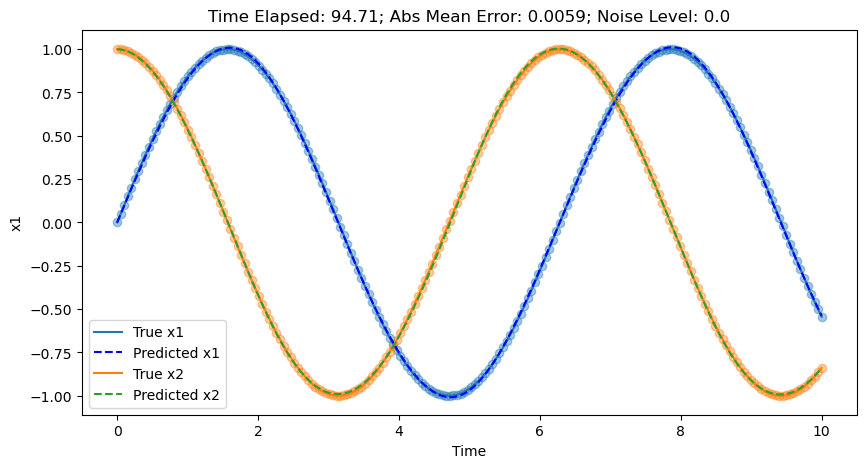

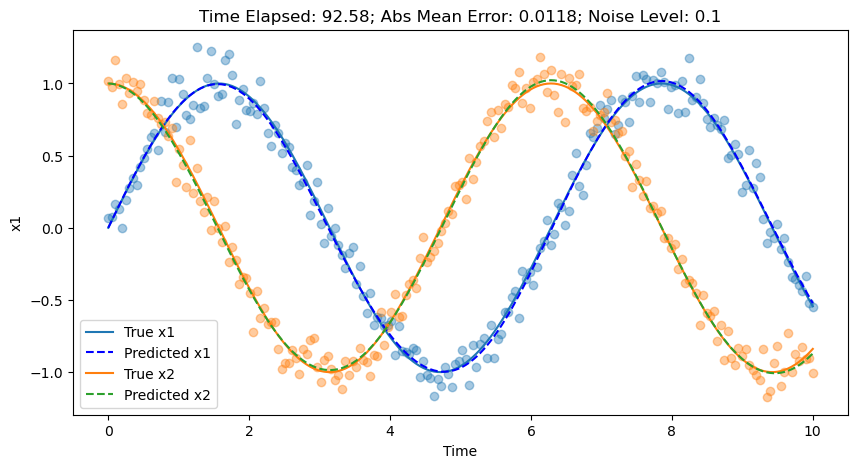

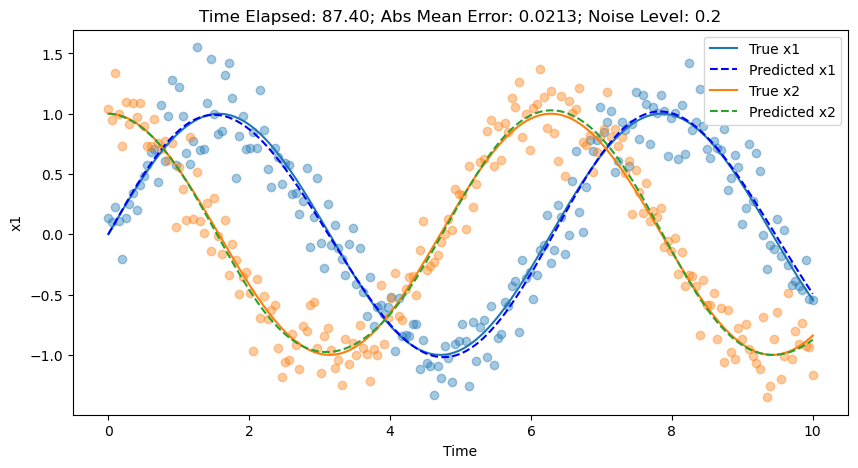

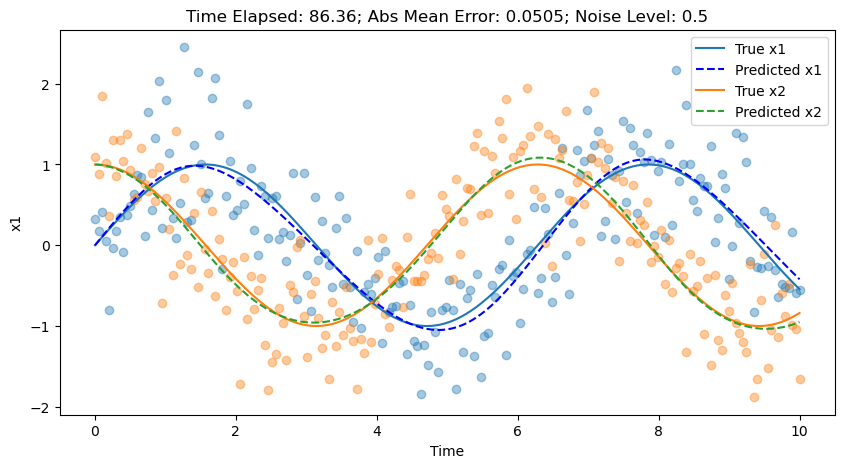

In [15]:
for i in range(len(y_pred_results)):
    result = y_pred_results[str(i)]
    y_pred = np.array(result["predictions"])
    y_noisy = np.array(result["y_noisy"])
    y = np.array(y)
    plt.figure(figsize=(10, 5))
    plt.plot(t, y[:, 0], label='True x1')
    plt.scatter(t, y_noisy[:, 0], alpha = 0.4)
    plt.plot(t, y_pred[:, 0], 'b--', label='Predicted x1')
    plt.plot(t, y[:, 1], label='True x2')
    plt.plot(t, y_pred[:, 1], '--', label='Predicted x2')
    plt.scatter(t, y_noisy[:, 1], alpha = 0.4)
    plt.xlabel('Time')
    plt.ylabel('x1')
    plt.legend()
    mae = np.mean(np.abs(y_pred - y))
    plt.title(f'Time Elapsed: {result["time_elapsed"]:.2f}; Abs Mean Error: {mae:.4f}; Noise Level: {result["noise_level"]}')
    plt.show()